<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Retrieve-and-transform-data" data-toc-modified-id="Retrieve-and-transform-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Retrieve and transform data</a></span><ul class="toc-item"><li><span><a href="#Process-and-add-up-all-provinces/states-into-one-row-per-country" data-toc-modified-id="Process-and-add-up-all-provinces/states-into-one-row-per-country-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Process and add up all provinces/states into one row per country</a></span></li><li><span><a href="#List-of-all-affected-countries" data-toc-modified-id="List-of-all-affected-countries-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>List of all affected countries</a></span></li></ul></li><li><span><a href="#Current-situation-plots" data-toc-modified-id="Current-situation-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Current situation plots</a></span><ul class="toc-item"><li><span><a href="#Plot-trends-over-calendar-date-in-selected-countries" data-toc-modified-id="Plot-trends-over-calendar-date-in-selected-countries-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot trends over calendar date in selected countries</a></span></li><li><span><a href="#Plot-trends-over-days-since-start-of-local-outbreak-in-selected-countries" data-toc-modified-id="Plot-trends-over-days-since-start-of-local-outbreak-in-selected-countries-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot trends over days since start of local outbreak in selected countries</a></span></li><li><span><a href="#Smoothed-growth-factor" data-toc-modified-id="Smoothed-growth-factor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Smoothed growth factor</a></span></li><li><span><a href="#Confirmed-cases,-deaths-and-active-cases-in-some-other-countries,-linear-scale" data-toc-modified-id="Confirmed-cases,-deaths-and-active-cases-in-some-other-countries,-linear-scale-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Confirmed cases, deaths and active cases in some other countries, linear scale</a></span></li><li><span><a href="#Pie-charts" data-toc-modified-id="Pie-charts-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Pie charts</a></span></li></ul></li><li><span><a href="#Forecast-plots" data-toc-modified-id="Forecast-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forecast plots</a></span><ul class="toc-item"><li><span><a href="#Fit-a-logistic-curve-and-extrapolate-number-of-future-cases" data-toc-modified-id="Fit-a-logistic-curve-and-extrapolate-number-of-future-cases-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fit a logistic curve and extrapolate number of future cases</a></span></li><li><span><a href="#Modelling-fatality-probability-per-day-of-being-infected" data-toc-modified-id="Modelling-fatality-probability-per-day-of-being-infected-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Modelling fatality probability per day of being infected</a></span></li><li><span><a href="#Generate-history-of-active-cases;-how-many-people-have-been-sick-for-how-long?" data-toc-modified-id="Generate-history-of-active-cases;-how-many-people-have-been-sick-for-how-long?-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generate history of active cases; how many people have been sick for how long?</a></span></li><li><span><a href="#Simulate-future-development-based-on-history-and-probability-models" data-toc-modified-id="Simulate-future-development-based-on-history-and-probability-models-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Simulate future development based on history and probability models</a></span></li></ul></li></ul></div>

# COVID-19 data visualization

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports. Data from Johns Hopkins University.

An earlier version of the plot of cases per country since the start of the local outbreak was shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).   Another plot, of the average growth factor per country, was posted [here](https://www.reddit.com/r/dataisbeautiful/comments/fliec2/oc_covid19_growth_factor_over_time_in_various/).

Note that the Table of Contents links above don't work in the Github preview, but they do on [nbviewer](https://nbviewer.jupyter.org/github/JeroenKools/covid19/tree/master/).

Want to see these graphs for some other countries, or modify the values for the simulations? The easiest and quickest way to run the notebook and make modifications yourself is to open this notebook in [Colab](https://colab.research.google.com/github/JeroenKools/covid19/blob/master/COVID-19.ipynb).

## Setup

Import code and parameters from [`covid19_util.py`](covid19_util.py) and [`covid_processing.py`](covid19_processing.py).

In [1]:
%load_ext autoreload
%autoreload 2
import sys
is_colab = 'google.colab' in sys.modules
if is_colab and not "covid19" in sys.path:
  try:
    !git clone https://github.com/JeroenKools/covid19.git
  except e: pass
  sys.path.append("covid19")
from covid19_util import *
from covid19_processing import *

## Retrieve and transform data

Thia code cell retrieves the most recent raw data on confirmed cases, deaths, and recoveries from the Johns Hopkins data repository, <br>and transforms each set into a Pandas dataframe.

For validation, it then shows a summarized version of the confirmed cases dataframe.

In [2]:
data = Covid19Processing()

### Raw confirmed cases data, per region/state

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,...,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,...,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,...,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,...,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,...,197,238,428,566,673,790,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,...,0,0,0,0,0,0,2
464,NaN,Chad,15.4542,18.7322,0,0,0,...,0,0,0,0,0,0,1
465,NaN,El Salvador,13.7942,-88.8965,0,0,0,...,0,0,0,0,0,0,1
466,NaN,Fiji,-17.7134,178.0650,0,0,0,...,0,0,0,0,0,0,1


### Process and add up all provinces/states into one row per country 

This also adds in a few data points for China from before the start of the Johns Hopkins data, from [Wikipedia](https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020).

Then, display a summary of the confirmed cases by country table.

In [3]:
data.process()

### Table of confirmed cases by country

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19
Country/Region,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0,0,...,16,21,22,22,22
Albania,0.0,0.0,0.0,0,0,...,42,51,55,59,64
Algeria,0.0,0.0,0.0,0,0,...,48,54,60,74,87
Andorra,0.0,0.0,0.0,0,0,...,1,2,39,39,53
Antigua and Barbuda,0.0,0.0,0.0,0,0,...,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,0.0,0.0,0.0,0,0,...,1,6,10,15,23
Venezuela,0.0,0.0,0.0,0,0,...,10,17,33,36,42
Vietnam,0.0,0.0,0.0,0,2,...,56,61,66,75,85


### List of all affected countries

In [4]:
data.list_countries()

### 156 countries/territories affected:


Afghanistan          Albania              Algeria              Andorra              Antigua and Barbuda 
Argentina            Armenia              Australia            Austria              Azerbaijan          
Bahamas, The         Bahrain              Bangladesh           Barbados             Belarus             
Belgium              Benin                Bhutan               Bolivia              Bosnia and Herzego. 
Brazil               Brunei               Bulgaria             Burkina Faso         Cambodia            
Cameroon             Canada               Central African Re.  Chad                 Chile               
China                Colombia             Congo (Brazzaville)  Congo (Kinshasa)     Costa Rica          
Cote d'Ivoire        Croatia              Cruise Ship          Cuba                 Cyprus              
Czechia              Denmark              Djibouti             Dominican Republic   Ecuador             
Egypt                El Salvador          Equatorial Gu

## Current situation plots

### Plot trends over calendar date in selected countries

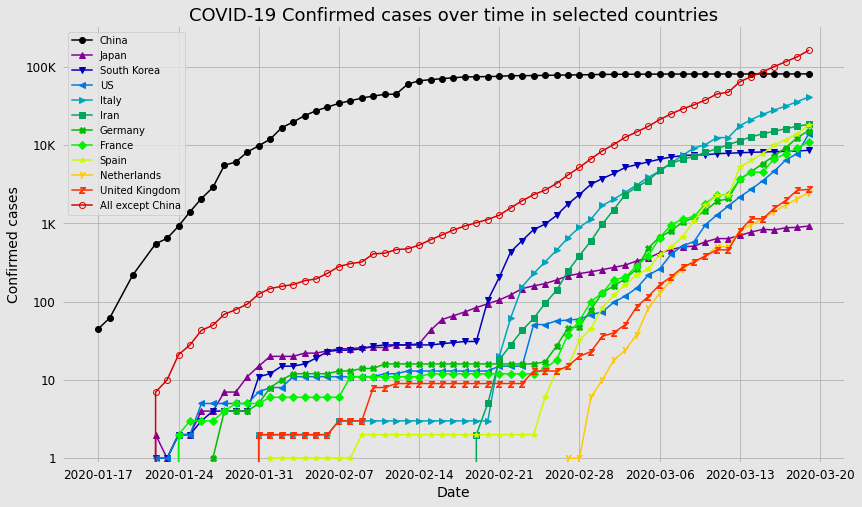

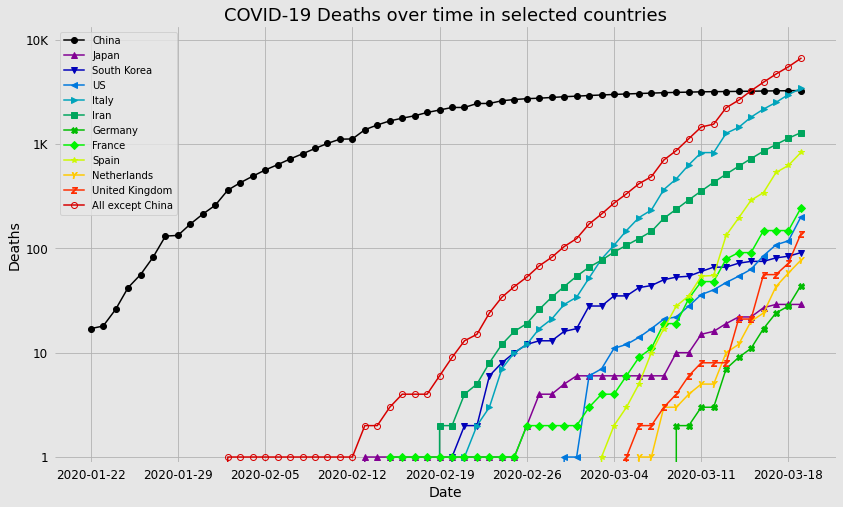

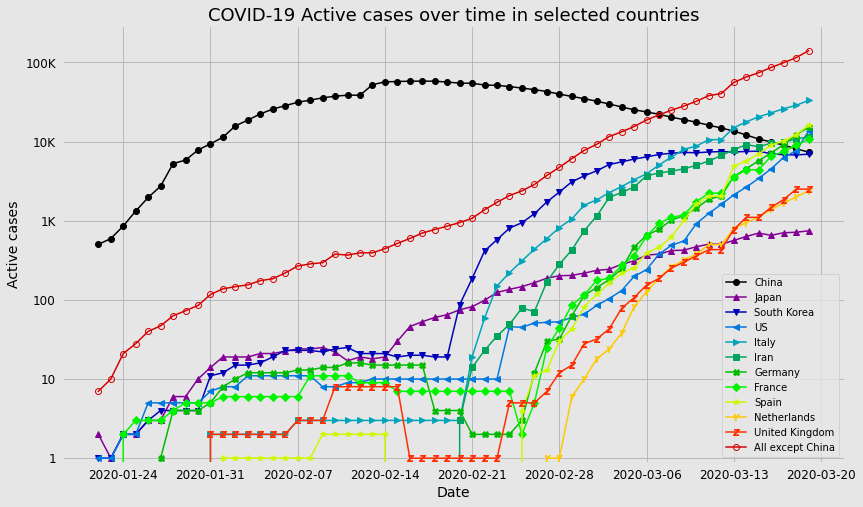

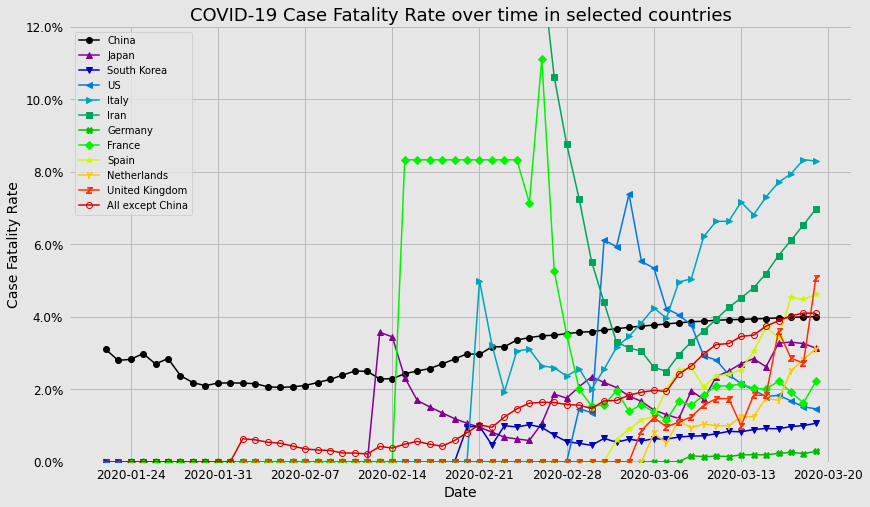

In [5]:
# The list of countries is easy to modify
countries_to_plot = ["China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "United Kingdom", "All except China"]

for y_metric in ["confirmed", "deaths", "active"]:
    data.plot("calendar_date", y_metric, countries_to_plot, fixed_country_colors=False)
    
data.plot("calendar_date", "deaths/confirmed", countries_to_plot, use_log_scale=False, fixed_country_colors=False)

### Plot trends over days since start of local outbreak in selected countries

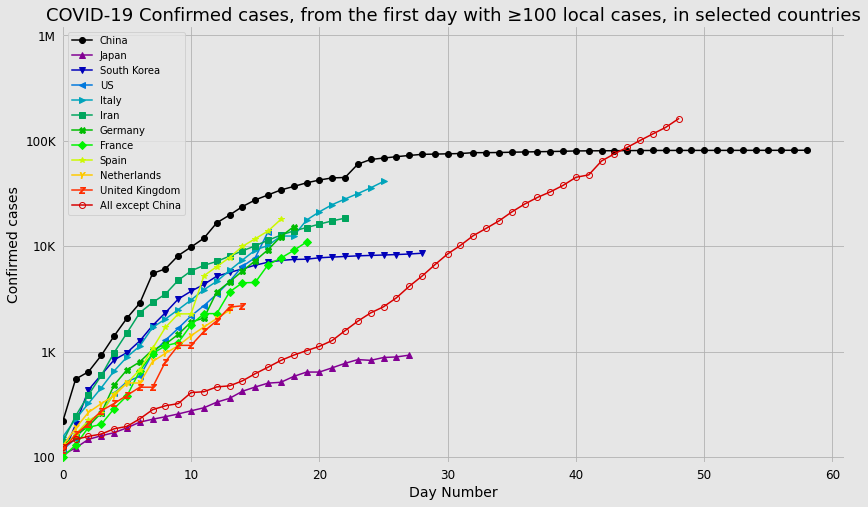

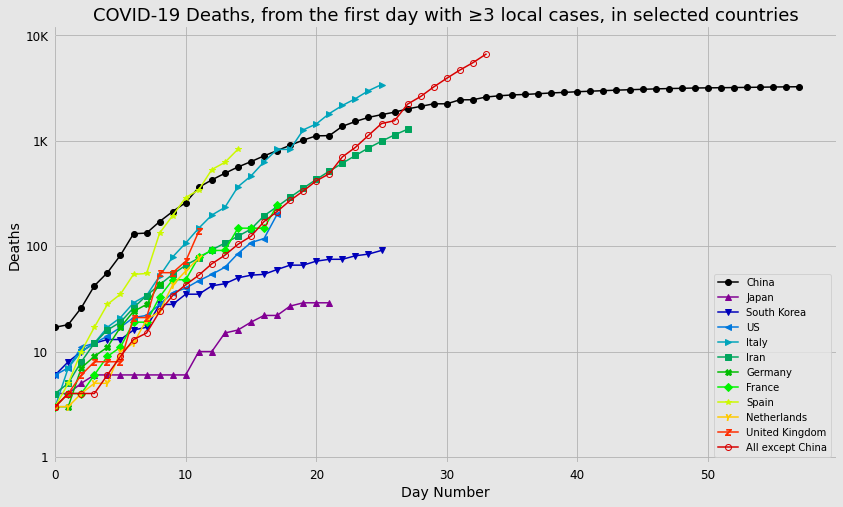

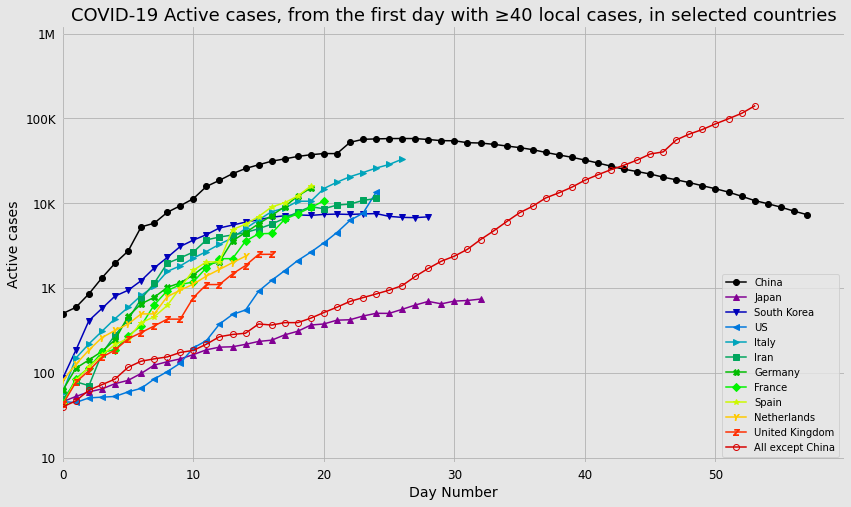

In [6]:
data.plot("day_number", "confirmed", countries_to_plot, min_cases=100, fixed_country_colors=False)
data.plot("day_number", "deaths", countries_to_plot, min_cases=3, fixed_country_colors=False)
data.plot("day_number", "active", countries_to_plot, min_cases=40, fixed_country_colors=False)

### Smoothed growth factor

The growth factor is the multiplier for the number of **new** cases per day. <br>For example, if there are 100 new cases on day *n* and 150 new cases on day *n+1*, the growth factor is 1.5.

* A growth factor larger than 1 means the outbreak is accelerating; it is growing exponentially.
* A growth factor of 1 means the outbreak is growing linearly.
* A growth factor of less than 1 means the outbreak is still growing, but slowing down.
* A growth factor of 0 means there are no new cases.

In this plot, the growth factor is averaged over 5 days to smooth out some large day-to-day variations. 

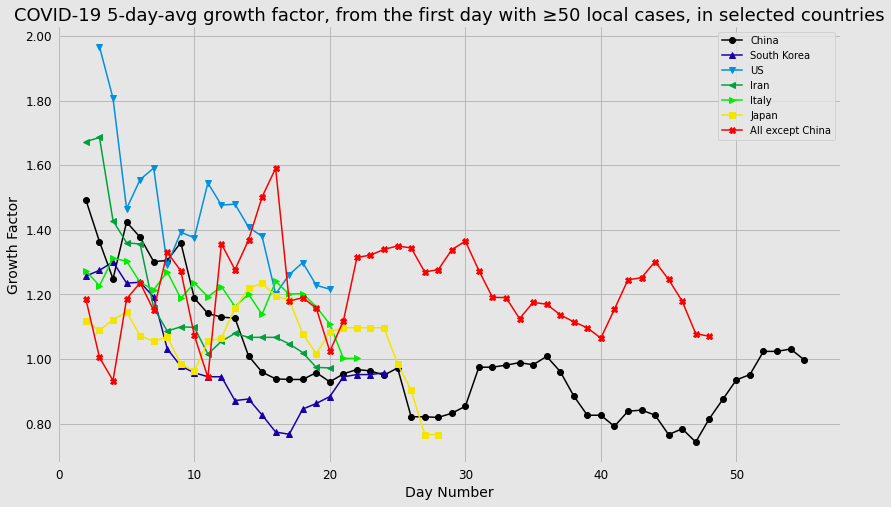

In [7]:
countries_to_plot2 = ["China", "South Korea", "US", "Iran", "Italy", "Japan", 
                      "All except China"]
data.plot("day_number", "growth_factor", countries_to_plot2, min_cases=50, n_days_average=5, fixed_country_colors=False)

### Confirmed cases, deaths and active cases in some other countries, linear scale

This shows how on a linear Y-axis, it becomes hard to examine the trend in all but the top few countries.

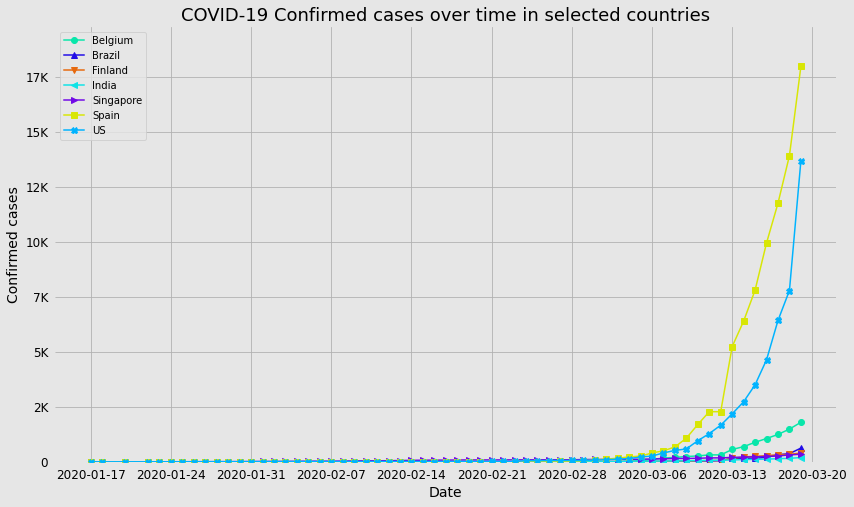

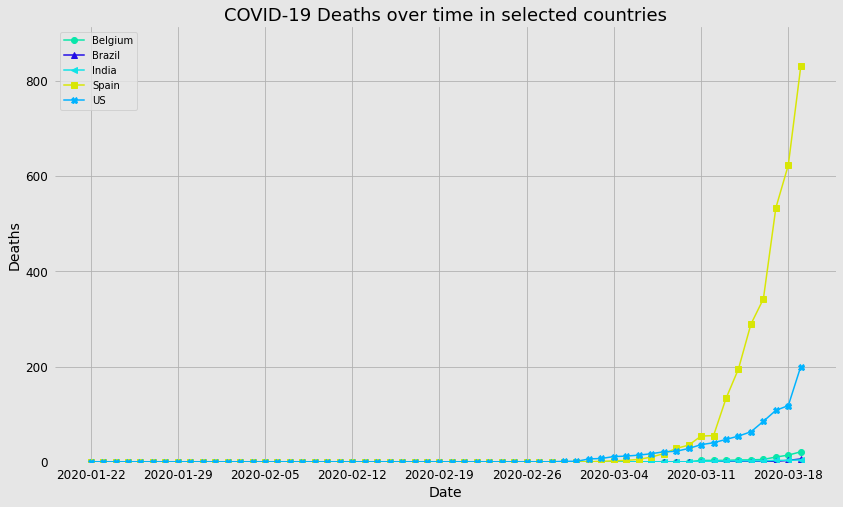

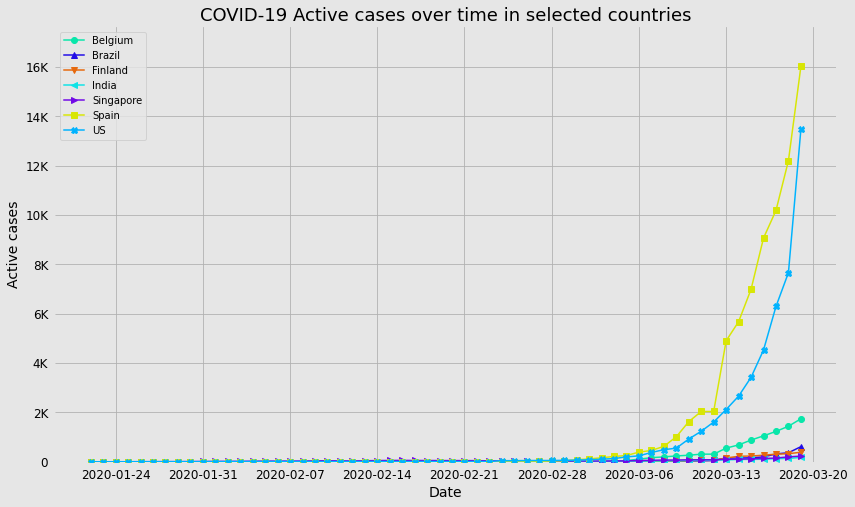

In [8]:
for y_metric in ["confirmed", "deaths", "active"]:
    data.plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Finland", "India", "Singapore", "Spain", "US"],
         use_log_scale=False)

### Pie charts

Everybody loves pie charts.

**TO DO**: 
* Base pie slice color on country name, rather than on rank

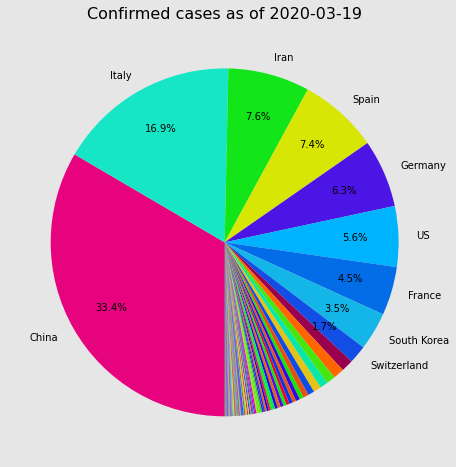

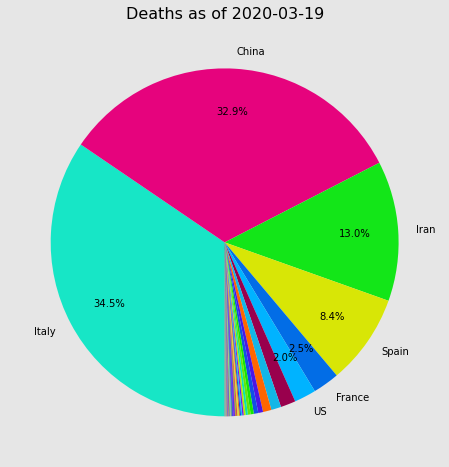

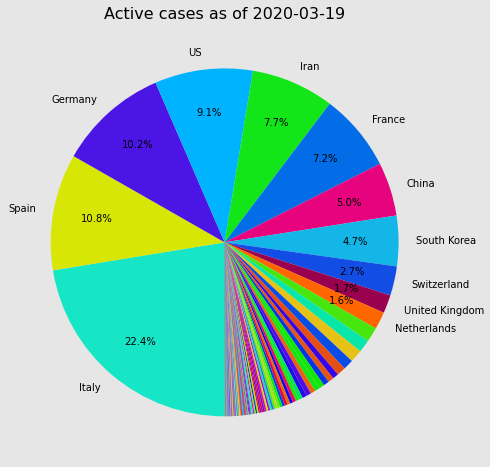

In [9]:
for y_metric in ["confirmed cases", "deaths", "active cases"]:
    data.plot_pie(y_metric)

## Forecast plots

First, model the probability distribution of dying after a given number of days.

We can consider a case recovered if they survive for a long enough time.

### Fit a logistic curve and extrapolate number of future cases

This tries to fit a [logistic](https://en.wikipedia.org/wiki/Logistic_function) or 'S-shape' curve to the data so far. While it is reasonable to expect that the total number of cases in any epidemic will eventually roughly have such a shape, the crucial parameters are difficult to predict. For example, changes in spread rate due to policy changes, or the possibility of a second wave of infections from another country are not captured at all.

For some countries the results look plausible enough, while for some others it can give extremely unlikely results, like predicting a number of cases that's many times the country's population.

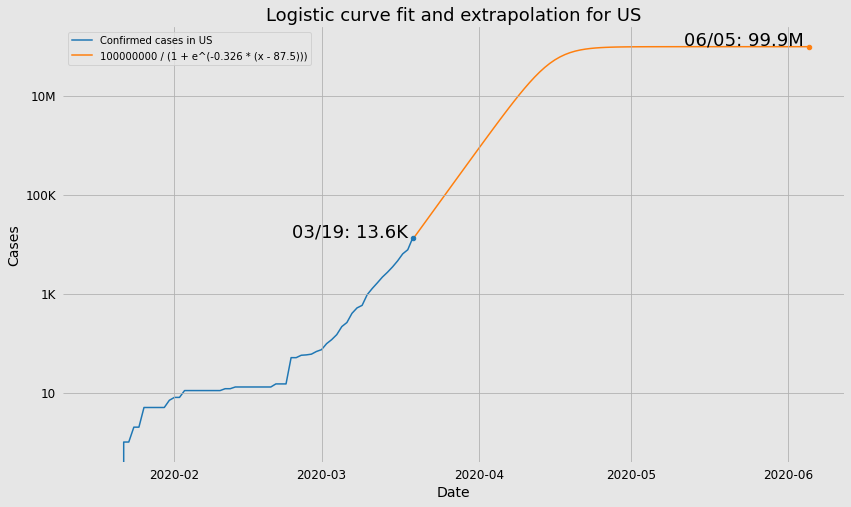

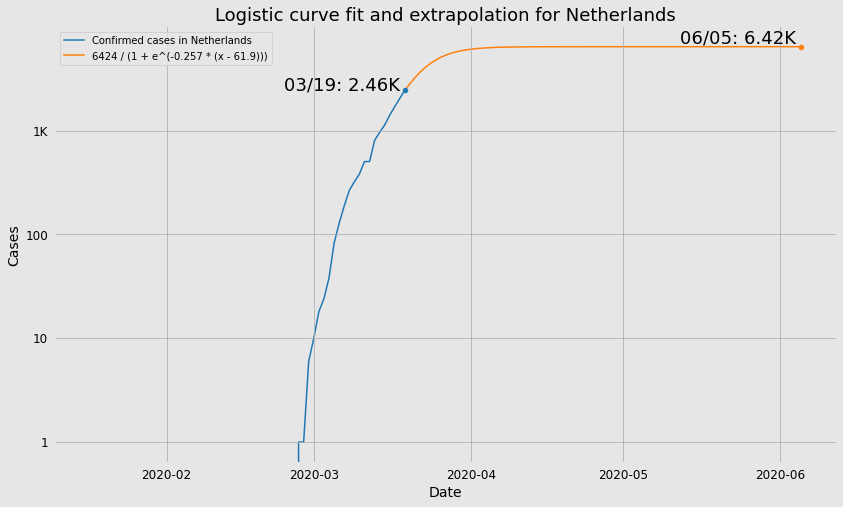

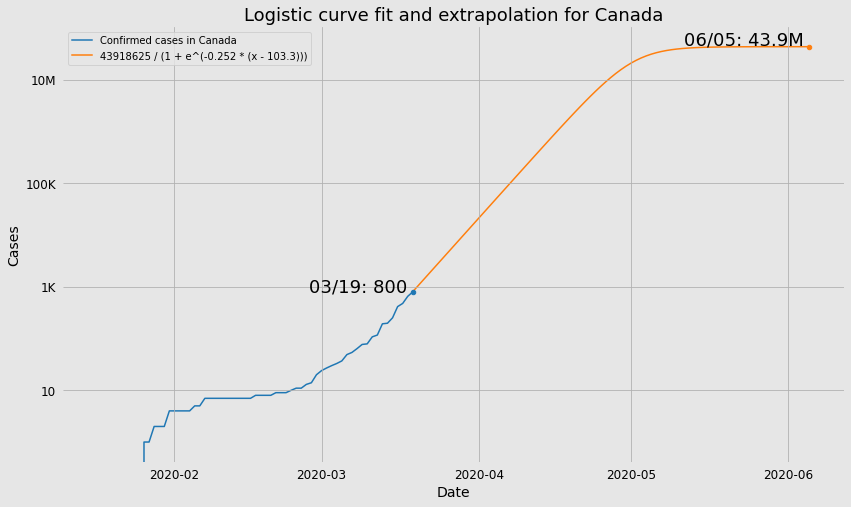

In [10]:
data.curve_fit("US", days=140)
data.curve_fit("Netherlands", days=140)
data.curve_fit("Canada", days=140)

### Modelling fatality probability per day of being infected

Input CFR: 3.00%. Model result: 97.00% of being alive after 21 days

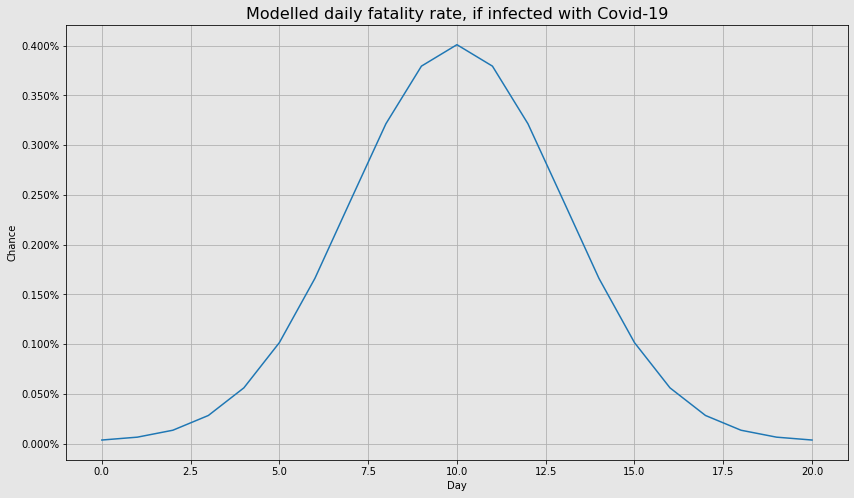

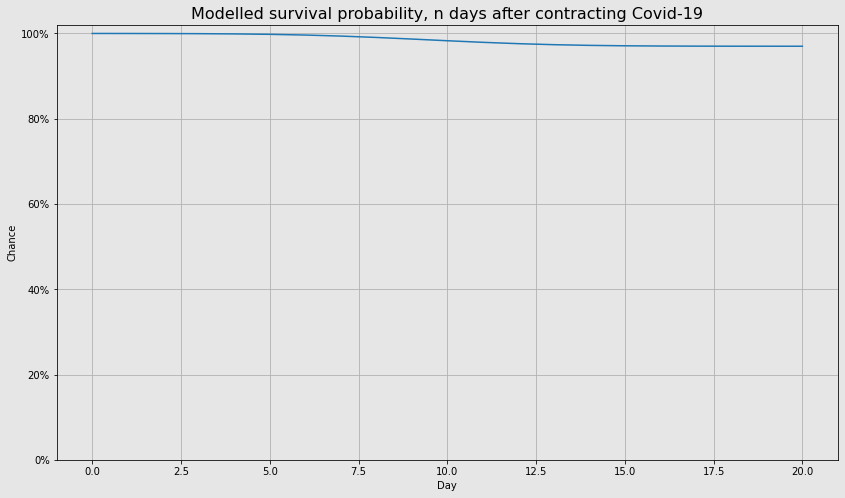

In [11]:
death_chance_per_day(cfr=0.03, sigma=3, length=21, do_plot=True)

### Generate history of active cases; how many people have been sick for how long?

Data on **how long** people have been sick is not available, so it is reconstructed using the assumption that new resolved cases (either death or recovery) always happens to the cases that have been active the longest. In other words, I assume a First-In-First-Out model.

In [12]:
data.simulate_country_history(country="US", population=330e6, history_length=7, show_result=True);

<br>**First 10 days in the US, showing a 7-day case duration history:**

,confirmed,deaths,recovered,active,active_0,active_1,active_2,active_3,active_4,active_5,active_6
2020-01-17,0,0,0,0,0,0,0,0,0,0,0
2020-01-18,0,0,0,0,0,0,0,0,0,0,0
2020-01-20,0,0,0,0,0,0,0,0,0,0,0
2020-01-22,1,0,0,1,1,0,0,0,0,0,0
2020-01-23,1,0,0,1,0,1,0,0,0,0,0
2020-01-24,2,0,0,2,1,0,1,0,0,0,0
2020-01-25,2,0,0,2,0,1,0,1,0,0,0
2020-01-26,5,0,0,5,3,0,1,0,1,0,0
2020-01-27,5,0,0,5,0,3,0,1,0,1,0
2020-01-28,5,0,0,5,0,0,3,0,1,0,1


### Simulate future development based on history and probability models

Please note that this is very speculative, and highly dependent on:

* The value chosen for the growth factor. This determines how many people will be infected in the next day of the simulation, relative to the last day. If there are 200 new cases on 3/11 and the growth factor is 1.1, there will be 220 new cases on 3/12. <br><br>The input for growth factor is a list that gets interpolated to the same length as the number of days to simulate. <br><br> For example, simulating 5 days with a growth_rate_trend of `[1.1, 1.0]` will use growth rates of `[1.1, 1.075, 1.05, 1.025, 1.00]`.


* The value chosen for case fatality rate (cfr); evidence so far suggests a range from 0.01 to 0.06


* The number of new cases in the country in the last day

Other limitations of the simulation:

* Doesn't consider incubation time 
* Doesn't have an R0 parameter (uses growth factor instead). **TO DO**: reconsider this approach.
* Doesn't factor in international travel and potential recontamination / second and later waves.

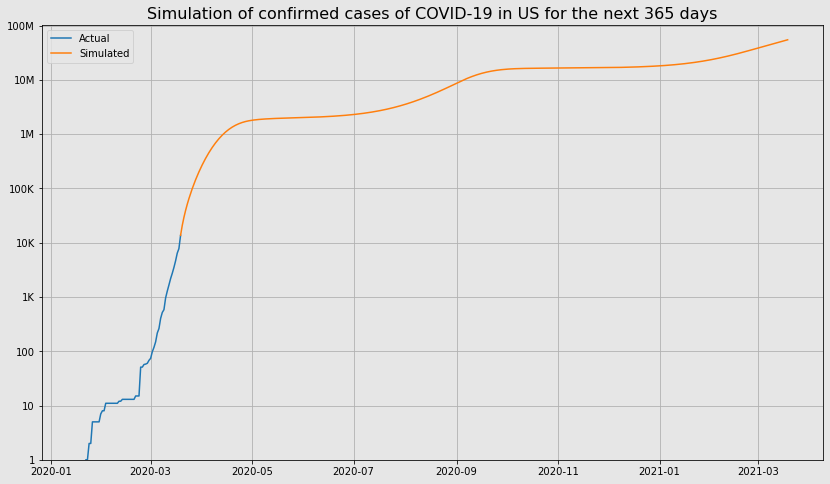

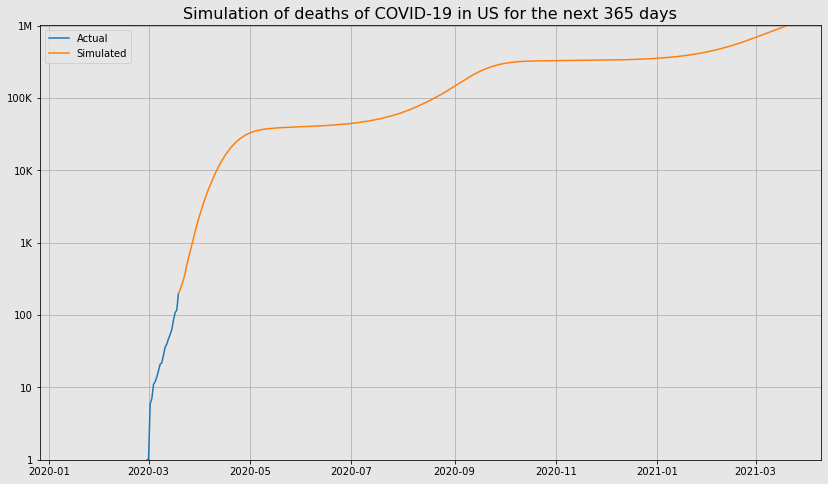

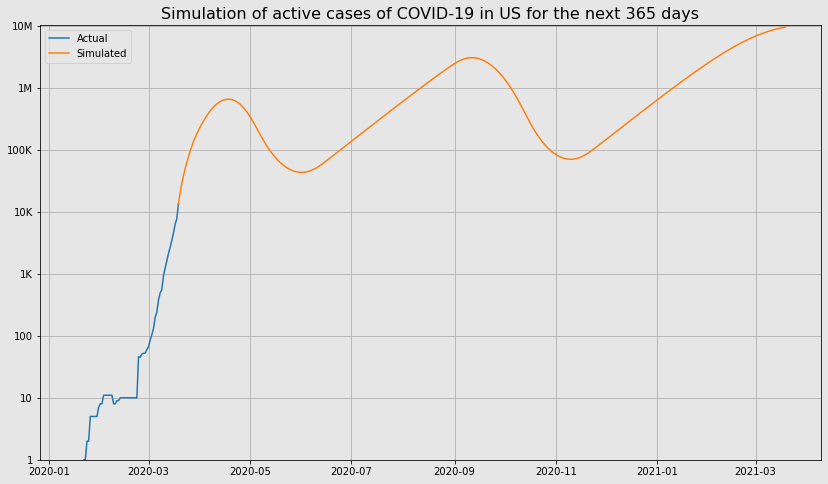

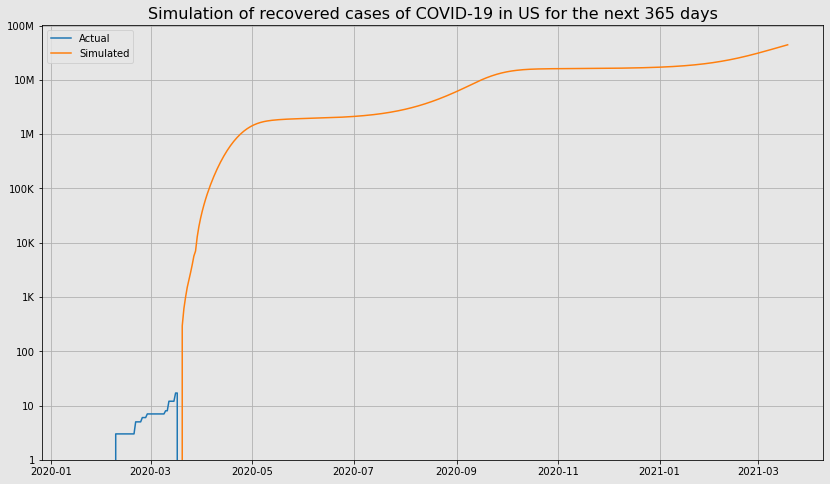

In [13]:
simulation = data.plot_simulation(country="US", days = 365, 
                     growth_rate_trend=[1.20]   +     # current value
                                       [0.88]*1 +     # lockdown for a while
                                       [1.05]*3 +     # long term lockdown is untenable
                                       [0.88]*1 +     # lockdown some more
                                       [1.05]*4,      # long term lockdown is untenable
                     history_length=10,
                     do_log=True)
